https://zerofromlight.com/blogs/detail/68/#_1

# データの準備

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=['Price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((16512, 8), (4128, 8))

In [2]:
train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

In [3]:
def round_number(df):
    """
    指定された属性の値を四捨五入し整数に置き換える
    """
    ave_columns = ['AveRooms', 'AveBedrms', 'AveOccup']

    for col in ave_columns:
        df[col] = np.round(df[col])
    return df


def std_exclude(df):
    """
    標準偏差の２倍以上の値は取り除く
    """
    columns = df[['MedInc', 'AveRooms', 'Population', 'AveOccup']].columns

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        boder = np.abs(df[col] - mean) / std
        df = df[(boder < 2)]

    return df


def category(df):
    """
   その区域の人口は、少ない（few）か、普通（usually）か、多い（many）か。
    大体のの区域では600人から3000人ということから、この範囲を指標とする。
    """
    if df < 600:
        return 'few'
    elif df > 3000:
        return 'many'
    else:
        return 'usually'


""" 上３つの関数をまとめたカスタム変換器"""
def custom_conversion(dataframe):
    df = dataframe.copy()
    df = round_number(df)

    # サンプルの調査ミスとして取り除く
    df = df[df['HouseAge'] < 52]

    # サンプルの調査ミスとして取り除く
    df = df[df['Price'] < 5]
    df = std_exclude(df)

    # 平均部屋数に対して平均寝室数を比較する
    df['Bedrms_per_Rooms'] = df['AveBedrms'] / df['AveRooms']
    df['Population_Feature'] = df['Population'].apply(category)

    # カテゴリー属性をダミー変数化する
    feature_dummies = pd.get_dummies(df['Population_Feature'], drop_first=True)
    df = pd.concat([df, feature_dummies], axis=1)

    # Xを説明変数、yを目的変数に代入しておく
    X = df.drop(['AveBedrms', 'Price', 'Population_Feature'], axis=1)
    y = df['Price']

    return X, y

In [4]:
X, y = custom_conversion(train_set)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_s = scaler.fit_transform(X)

# 検証セットを使って学習曲線を描く

In [7]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_s, y)

lin_pred = lin_reg.predict(X_s)
lin_mse = mean_squared_error(y, lin_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.5754619586800496

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)

In [9]:
# 訓練用と検証用の結果を納める
train_errors, val_errors = [], []

# 10個目のデータから順に、10、110と100個飛ばして回す
for m in range(10, len(X_train), 100):

    # 順番に110, 210, 310, ...、と訓練し、検証セットとの汎化誤差を比べる
    lin_reg.fit(X_train[:m], y_train[:m])
    y_train_predict = lin_reg.predict(X_train[:m])
    y_val_predict = lin_reg.predict(X_val)
    train_mse = mean_squared_error(y_train[:m], y_train_predict)
    val_mse = mean_squared_error(y_val, y_val_predict)
    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)

    # それぞれのRMSEをリストに収める
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

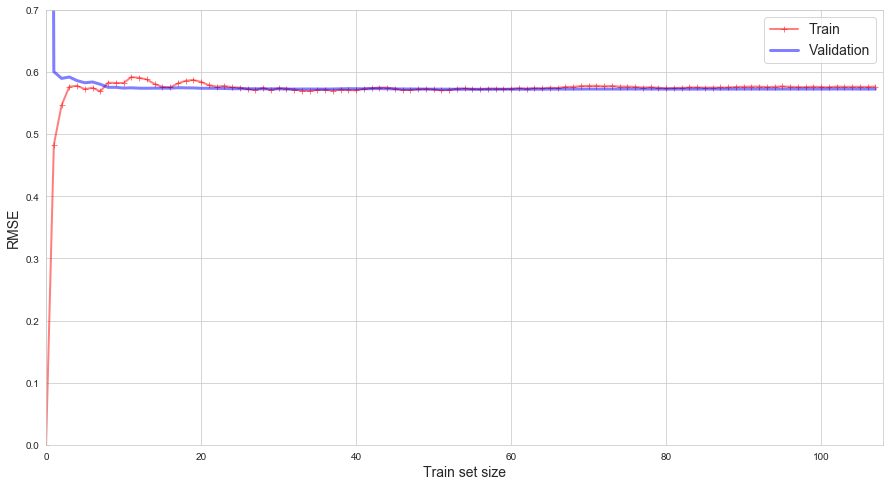

In [10]:
import matplotlib.pyplot as plt

 # 画像サイズ
plt.figure(figsize=(15, 8))
 # 訓練セット
plt.plot(train_errors, "r-+", alpha=0.5, linewidth=2, label="Train")
 # 検証セット
plt.plot(val_errors, "b-", alpha=0.5, linewidth=3, label="Validation")
 # 凡例
plt.legend(loc="upper right", fontsize=14)
 # x軸の名前
plt.xlabel("Train set size", fontsize=14)
 # y軸の名前
plt.ylabel("RMSE", fontsize=14)
 # x軸のメモリは0からtrain_errorsサイズを指定
 # y軸のメモリは0から0.7に指定（この範囲にだいたい分布がされるので）
plt.axis([0, len(train_errors), 0, 0.7])
plt.savefig('Linear_error.png')
plt.show()

In [11]:
# データフレーム用の空リスト
# 訓練誤差と検証誤差の誤差を格納
generalization_error = []

# model_nameにモデル名を入れる
def plot_learning_curves(model, X, y, model_name=None):

    # japanize_matplotlibで日本語設定
    import japanize_matplotlib
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []

    # 10個目のデータから順に、110、210と310個飛ばして回す
    for m in range(10, len(X_train), 100):

        # 順番に10, 110, 210, ...、と訓練し、検証誤差を出す
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_mse = mean_squared_error(y_train[:m], y_train_predict)
        val_mse = mean_squared_error(y_val, y_val_predict)
        train_rmse = np.sqrt(train_mse)
        val_rmse = np.sqrt(val_mse)

        # それぞれのRMSEをリストに収める
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

    # それぞれの一番最終のRMSEの誤差を出す
    train_val_error = np.round(train_errors[-1] - val_errors[-1], 4)

    # 訓練誤差と検証誤差の誤差を絶対値に置き換える
    train_val_error = np.abs(train_val_error)

    # データフレーム用の空リストに収める
    generalization_error.append(train_val_error)
    plt.figure(figsize=(15, 8))
    plt.plot(train_errors, "r-+", alpha=0.5, linewidth=2, label="訓練セット")
    plt.plot(val_errors, "b-", alpha=0.5, linewidth=3, label="検証セット")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("訓練セットの数", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

    # 最終のRMSEと、訓練・検証の差をタイトルに表示。
    plt.title('{0}の訓練セット誤差:{1}、検証セット誤差:{2}、その差は{3}'.format(model_name, 
                                                                    np.round(train_errors[-1], 4),
                                                                    np.round(val_errors[-1], 4),
                                                                    train_val_error), fontsize=18)

    plt.axis([0, len(train_errors), 0, 0.7])
    plt.savefig('{}_error.png'.format(model_name))
    plt.show()

## SVMの学習曲線

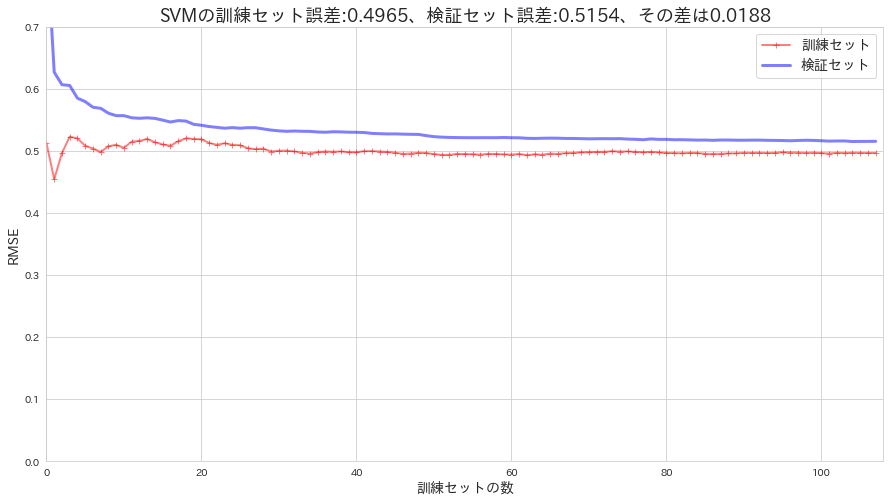

In [12]:
from sklearn.svm import SVR

svm_reg = SVR(gamma='auto')

plot_learning_curves(svm_reg, X_s, y, model_name='SVM')

## RandomForestの学習曲線

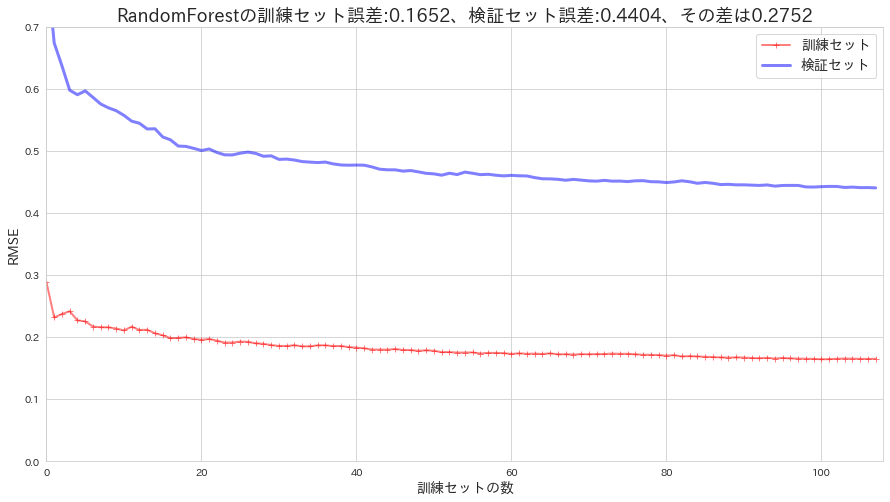

In [13]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

plot_learning_curves(forest_reg, X_s, y, model_name='RandomForest')

## GradientBoostingsTreeの学習曲線

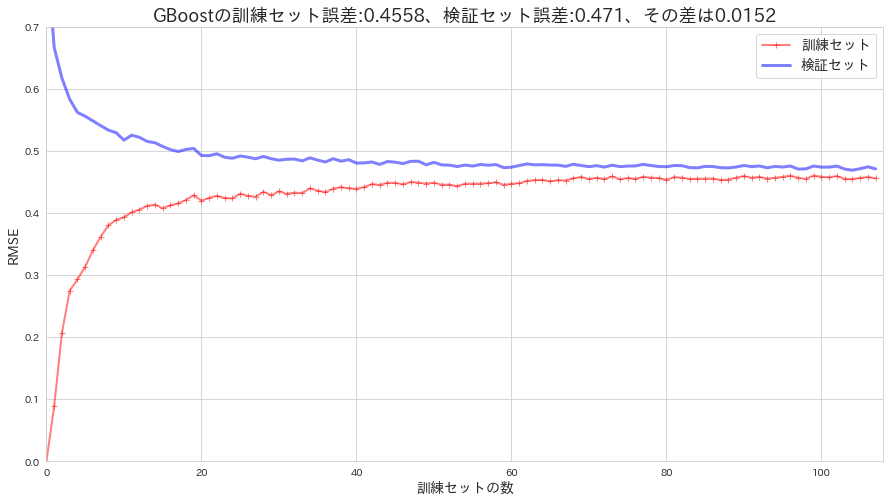

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(random_state=42)

plot_learning_curves(gb_reg, X_s, y, model_name='GBoost')

## MLPの学習曲線

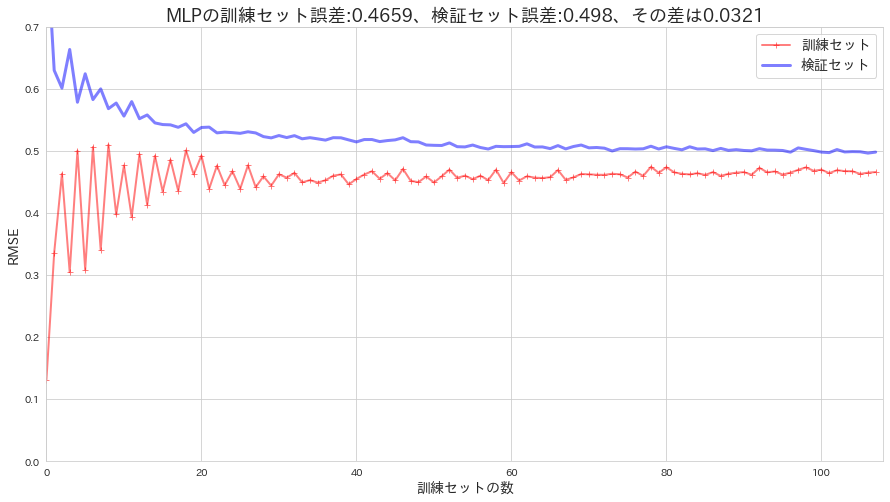

In [15]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(max_iter=1500, random_state=42)

plot_learning_curves(mlp_reg, X_s, y, model_name='MLP')

In [16]:
import pandas as pd

df_error = pd.DataFrame(generalization_error,
                        index=['SVM', 'RandomForest', 'GBoost', 'MLP'],
                        columns=['Normal'])
df_error

,Normal
SVM,0.0188
RandomForest,0.2752
GBoost,0.0152
MLP,0.0321


## SVM（ランダムサーチ）の学習曲線

In [17]:
from sklearn.model_selection import RandomizedSearchCV

 # kernel：　ガウスRBFカーネル・線形カーネル・多項式カーネル
 # C：　正則化ハイパーパラメータ、小さくすると制御を強める
 # degree：　多項式回帰の次元設定
param_random = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.001, 0.01, 1],
    'degree': [2],
    'gamma': ['auto'],
}

svm_reg = SVR()

svm_random_search = RandomizedSearchCV(svm_reg,
                                       param_random,
                                       cv=5,
                                       scoring='neg_mean_squared_error',
                                       n_iter=9,
                                       random_state=42)

svm_random_search.fit(X_s, y)

svm_random_search.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 1}

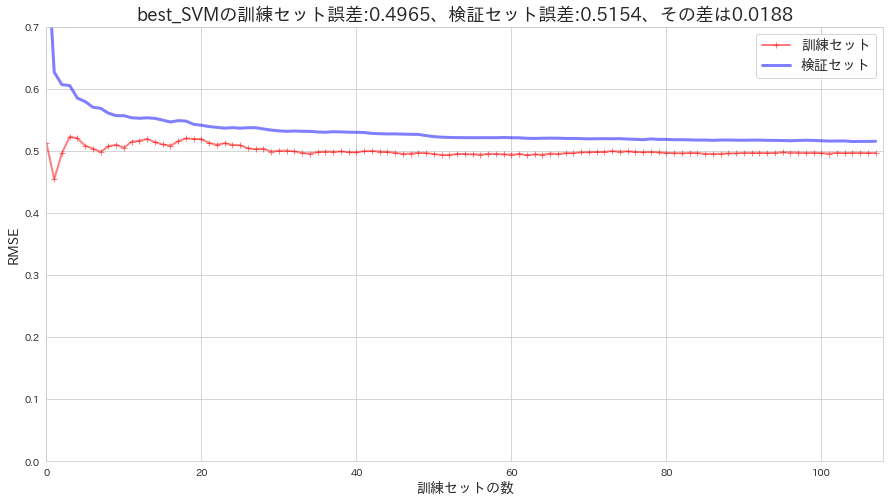

In [19]:
generalization_error = []

plot_learning_curves(svm_random_search.best_estimator_, X_s, y, model_name='best_SVM')

## RandomForest（ランダムサーチ）の学習曲線

In [20]:
 # max_depth: 最大ノード数（正則化の制御、多項式回帰のdegreeのようなもの）
 # n_estimators: 決定木の個数
random_search = {'max_depth': [1, 2],
                 'n_estimators': [300, 500, 1000, 2000],
                 'random_state': [42]}

forest_reg = RandomForestRegressor()

forest_random_search = RandomizedSearchCV(forest_reg,
                                          random_search,
                                          cv=5,
                                          n_jobs=-1,
                                          scoring='neg_mean_squared_error',
                                          n_iter=8,
                                          random_state=42)

forest_random_search.fit(X_s, y)

forest_random_search.best_params_

{'random_state': 42, 'n_estimators': 500, 'max_depth': 2}

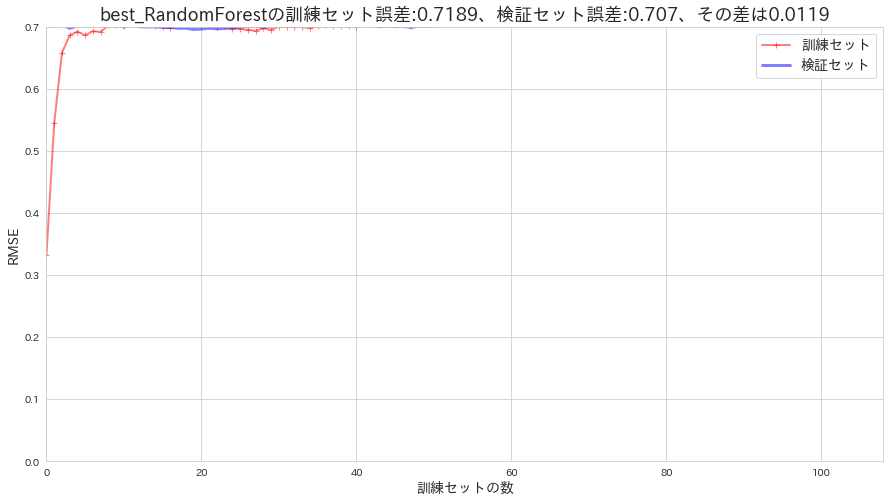

In [21]:
plot_learning_curves(forest_random_search.best_estimator_, X_s, y, model_name='best_RandomForest')

## GradientBoostingTree（ランダムサーチ）の学習曲線

In [22]:
 # max_depth: 最大ノード数（正則化）
 # n_estimators: 決定木の個数
random_search = {'max_depth': [1, 2],
                 'n_estimators': [300, 500, 1000, 2000],
                 'random_state': [42]}

gb_reg = GradientBoostingRegressor()

gb_random_search = RandomizedSearchCV(gb_reg,
                                      random_search,
                                      cv=5,
                                      n_jobs=-1,
                                      scoring='neg_mean_squared_error',
                                      n_iter=8,
                                      random_state=42)

gb_random_search.fit(X_s, y)

gb_random_search.best_params_

{'random_state': 42, 'n_estimators': 2000, 'max_depth': 2}

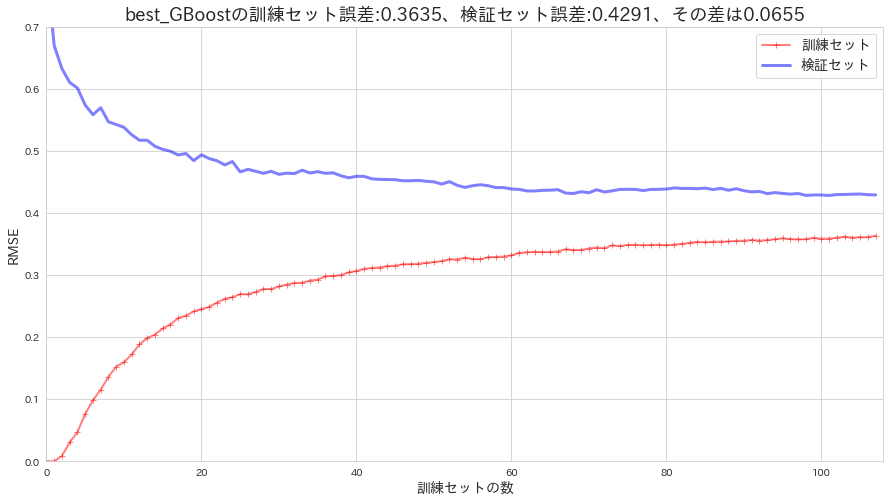

In [23]:
plot_learning_curves(gb_random_search.best_estimator_, X_s, y, model_name='best_GBoost')

## MLP（ランダムサーチ）の学習曲線

In [24]:
 # hidden_layer_sizes: ニューロンと層の数
 # learning_rate_init: 重みを更新するステップサイズの制御
 # max_iter: エポック数
 # epsilon: ReLuの正則化ハイパーパラメータ値
random_search = {'hidden_layer_sizes': [(100),
                                        (100, 100),
                                        (20, 30, 50, 30, 20),
                                        (20, 50, 80, 50, 20),
                                        (20, 100, 100, 100, 20)],
                 'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
                 'epsilon': [0.01, 0.1, 0.2, 1],
                 'max_iter': [1500],
                 'random_state': [42]}

mlp_reg = MLPRegressor()

mlp_random_search = RandomizedSearchCV(mlp_reg,
                                       random_search,
                                       cv=5,
                                       n_jobs=-1,
                                       scoring='neg_mean_squared_error',
                                       n_iter=20,
                                       random_state=42)

mlp_random_search.fit(X_s, y)

mlp_random_search.best_params_

{'random_state': 42,
 'max_iter': 1500,
 'learning_rate_init': 0.001,
 'hidden_layer_sizes': (20, 30, 50, 30, 20),
 'epsilon': 0.01}

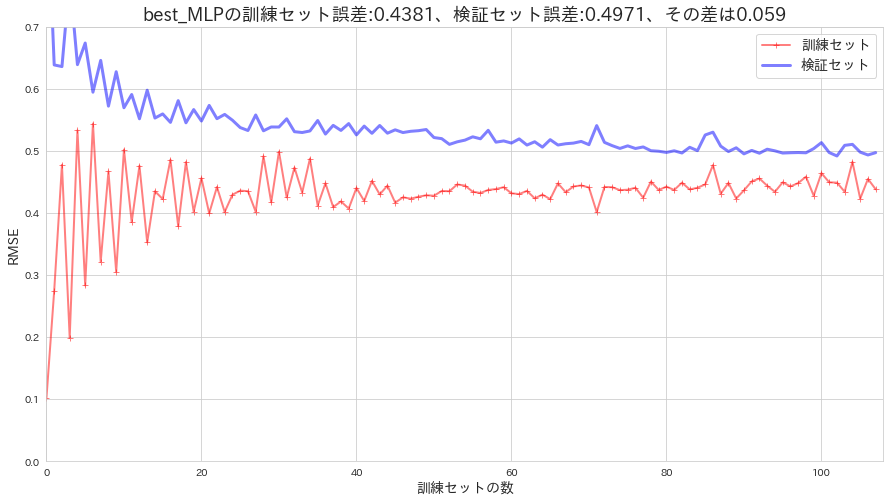

In [25]:
plot_learning_curves(mlp_random_search.best_estimator_, X_s, y, model_name='best_MLP')

In [26]:
df_error['Random_Search'] = generalization_error
df_error

,Normal,Random_Search
SVM,0.0188,0.0188
RandomForest,0.2752,0.0119
GBoost,0.0152,0.0655
MLP,0.0321,0.0590


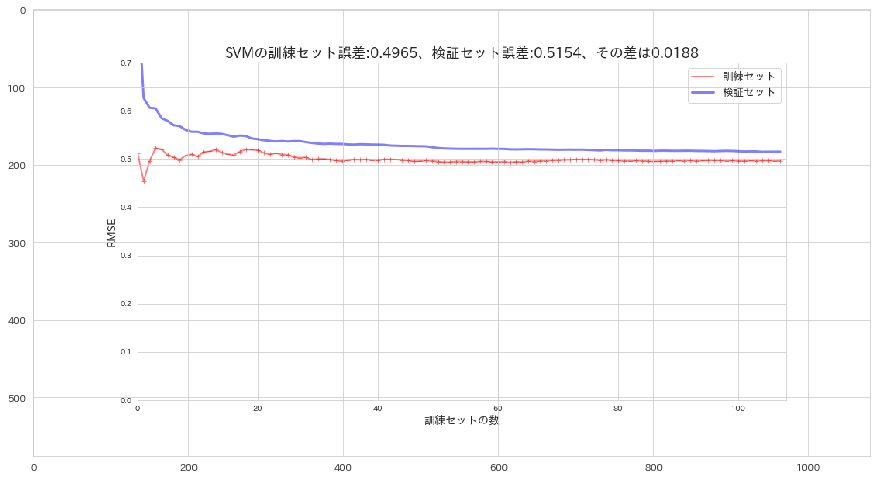

In [27]:
# SVMの学習曲線
svm_img = plt.imread('SVM_error.png')

plt.figure(figsize=(15, 12))
plt.imshow(svm_img)
plt.savefig('imshow_svm.png')
plt.show()

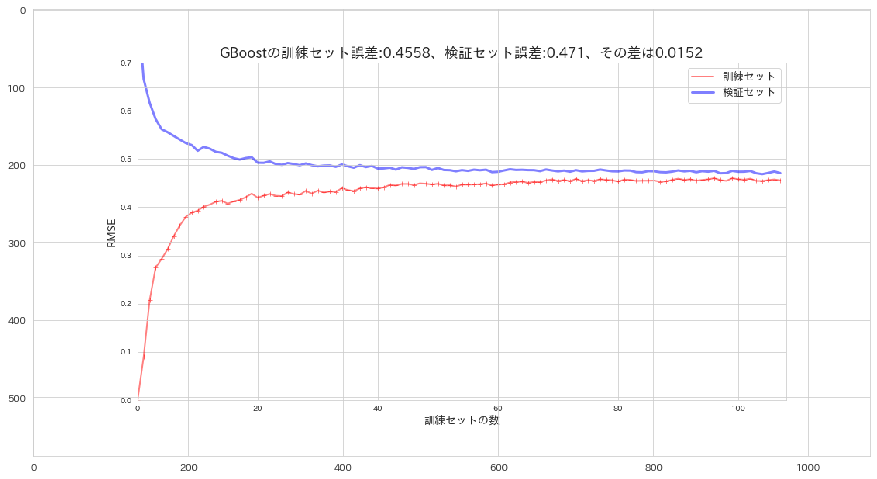

In [28]:
# GradientBoostingTreeの学習曲線

gb_img = plt.imread('GBoost_error.png')

plt.figure(figsize=(15, 12))
plt.imshow(gb_img)
plt.savefig('imshow_gb.png')
plt.show()

## テストセットの評価

In [29]:
gb_reg.fit(X_s, y)

X_test, y_test = custom_conversion(test_set)

 # スケーリング
X_test_s = scaler.transform(X_test)

best_model_pred = gb_reg.predict(X_test_s)
best_model_mse = mean_squared_error(y_test, best_model_pred)
best_model_rmse = np.sqrt(best_model_mse)
best_model_rmse

0.47844037849867105

In [30]:
train_model_pred = gb_reg.predict(X_s)
train_model_mse = mean_squared_error(y, train_model_pred)
train_model_rmse = np.sqrt(train_model_mse)
train_model_rmse

0.4628402048901585

# 最良のモデルとスケーラーをpickleファイルに保存

In [31]:
import pickle

 # モデルの保存
 # 前回のモデルと被らないために、best_model_2とする
with open('best_model_2.pickle', 'wb') as f:
    pickle.dump(gb_reg, f)

 # スケーラーの保存
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

In [32]:
with open('best_model_2.pickle', 'rb') as f:
    best_model_2 = pickle.load(f)

best_model_2

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)